## Lung Cancer Analysis
Objective: Perform EDA and modeling

### Import necessary packages

In [355]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from kaggle.api.kaggle_api_extended import KaggleApi
import os

### Load Data

In [356]:

# Authenticate and download dataset if not already present
api = KaggleApi()
api.authenticate()

filename = "lung_cancer_prediction_dataset.csv"
if not os.path.exists(filename):
    api.dataset_download_files("aizahzeeshan/lung-cancer-risk-in-25-countries", path=".", unzip=True)

# Load dataset
data = pd.read_csv(filename)
df=data.copy()
df.head()


,ID,Country,Population_Size,Age,Gender,Smoker,Years_of_Smoking,Cigarettes_per_Day,Passive_Smoker,Family_History,...,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Early_Detection,Treatment_Type,Developed_or_Developing,Annual_Lung_Cancer_Deaths,Lung_Cancer_Prevalence_Rate,Mortality_Rate
0,0,China,1400,80,Male,Yes,30,29,No,No,...,Low,Yes,No,Poor,No,NaN,Developing,690000,2.44,0.0
1,1,Iran,84,53,Male,No,0,0,Yes,No,...,Low,Yes,No,Poor,No,NaN,Developing,27000,2.10,0.0
2,2,Mexico,128,47,Male,Yes,12,6,Yes,No,...,Medium,No,No,Poor,Yes,NaN,Developing,28000,1.11,0.0
3,3,Indonesia,273,39,Female,No,0,0,No,Yes,...,Low,No,No,Poor,No,NaN,Developing,40000,0.75,0.0
4,4,South Africa,59,44,Female,No,0,0,Yes,No,...,Medium,Yes,No,Poor,No,NaN,Developing,15000,2.44,0.0


### Exploratory Data Analysis

In [357]:
# Dataset shape, number of rows, number of cols, names of cols
print(f"\nDimension of data: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nColumns: {', '.join(df.columns)}")



Dimension of data: 220632 rows, 24 columns

Columns: ID, Country, Population_Size, Age, Gender, Smoker, Years_of_Smoking, Cigarettes_per_Day, Passive_Smoker, Family_History, Lung_Cancer_Diagnosis, Cancer_Stage, Survival_Years, Adenocarcinoma_Type, Air_Pollution_Exposure, Occupational_Exposure, Indoor_Pollution, Healthcare_Access, Early_Detection, Treatment_Type, Developed_or_Developing, Annual_Lung_Cancer_Deaths, Lung_Cancer_Prevalence_Rate, Mortality_Rate


In [358]:
# Features, non-null values & datatypes
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220632 entries, 0 to 220631
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           220632 non-null  int64  
 1   Country                      220632 non-null  object 
 2   Population_Size              220632 non-null  int64  
 3   Age                          220632 non-null  int64  
 4   Gender                       220632 non-null  object 
 5   Smoker                       220632 non-null  object 
 6   Years_of_Smoking             220632 non-null  int64  
 7   Cigarettes_per_Day           220632 non-null  int64  
 8   Passive_Smoker               220632 non-null  object 
 9   Family_History               220632 non-null  object 
 10  Lung_Cancer_Diagnosis        220632 non-null  object 
 11  Cancer_Stage                 8961 non-null    object 
 12  Survival_Years               220632 non-nul

In [359]:
#dublicated values
print("Total duplicate records: ", df.duplicated().sum())
print(f"Er zijn {df.duplicated(subset=df.columns.difference(['ID'])).sum()} inhoudelijke duplicaten, maar met unieke ID's.\n")
# missing values
print(f"Columns with missing values:\n{round(df.isna().sum()[df.isna().sum() > 0]/len(df),4)*100}")
print("\nComparison with target var:")
print(f"No-Cancer-diagnosis: {round((len(df[df['Lung_Cancer_Diagnosis']=='No'])/len(df)),4)*100}")

Total duplicate records:  0
Er zijn 252 inhoudelijke duplicaten, maar met unieke ID's.

Columns with missing values:
Cancer_Stage      95.94
Treatment_Type    96.98
dtype: float64

Comparison with target var:
No-Cancer-diagnosis: 95.94


In [360]:
# 'ID' als index instellen (if statement want by )
if 'ID' in df.columns:
    df.set_index('ID', inplace=True)
    print("\n'ID' column set as index!")
else:
    print("\nNo 'ID' column found, skipping index setting.")

# Optioneel: opnieuw dataset info bekijken
# df.info()


'ID' column set as index!


In [361]:
#checking on missingness at Random
from scipy.stats import chi2_contingency

target = 'Lung_Cancer_Diagnosis'
features = ['Cancer_Stage', 'Treatment_Type']
features_notMAR = []

for feat in features:
    if feat in df.columns:
        if df[feat].isnull().sum() == 0:
            print(f"Geen missende waarden in {feat}, overslaan.")
            continue

        # Make a binaire col 4 missingness
        df['_feature_missing'] = df[feat].isnull().astype(int)

        # Making Xtabel between missingness & target
        contingency_table = pd.crosstab(df['_feature_missing'], df[target])

        # Chi-kwadraat test
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        

        # interpreting  p-value
        if p_value < 0.05:
            print(f"Missingness in {feat} is NIET MAR (p = {p_value:.5f}), feature wordt verwijderd.")
            features_notMAR.append(feat)
        else:
            print(f"Missingness in {feat} is MAR (p = {p_value:.5f}), feature blijft behouden.")

    else:
        print(f"Kolom {feat} niet gevonden in dataset.")

# Features die niet MAR zijn verwijderen
if features_notMAR:
    df.drop(columns=features_notMAR, inplace=True)
    print(f"\nVerwijderde kolommen: {', '.join(features_notMAR)}")

# Extra kolom opschonen
df.drop(columns=['_feature_missing'], inplace=True, errors='ignore')

# Samenvatting tonen
with pd.option_context('display.max_columns', None):
    print("\nDataset Info na opschoning:")
    df.info()


Missingness in Cancer_Stage is NIET MAR (p = 0.00000), feature wordt verwijderd.
Missingness in Treatment_Type is NIET MAR (p = 0.00000), feature wordt verwijderd.

Verwijderde kolommen: Cancer_Stage, Treatment_Type

Dataset Info na opschoning:
<class 'pandas.core.frame.DataFrame'>
Index: 220632 entries, 0 to 220631
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Country                      220632 non-null  object 
 1   Population_Size              220632 non-null  int64  
 2   Age                          220632 non-null  int64  
 3   Gender                       220632 non-null  object 
 4   Smoker                       220632 non-null  object 
 5   Years_of_Smoking             220632 non-null  int64  
 6   Cigarettes_per_Day           220632 non-null  int64  
 7   Passive_Smoker               220632 non-null  object 
 8   Family_History               220632 non-null  object 


In [362]:
# Identificeer numerieke features
num_features = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
print(f"Numeric features:\n{num_features}")

# Identificeer categorische features
cat_features = [col for col in df.columns if df[col].dtype == 'object']
print(f"\nCategoric features:\n{cat_features}")

# Identificeer binaire features
bin_features = [col for col in cat_features if df[col].nunique() == 2]
print(f"\nBinairy features:\n{bin_features}")

# Identificeer categorische features met meer dan 2 categorieën
morecat_features = [col for col in cat_features if df[col].nunique() > 2]
print(f"\nCategorical features with more than 2 cats:\n{morecat_features}")

Numeric features:
['Population_Size', 'Age', 'Years_of_Smoking', 'Cigarettes_per_Day', 'Survival_Years', 'Annual_Lung_Cancer_Deaths', 'Lung_Cancer_Prevalence_Rate', 'Mortality_Rate']

Categoric features:
['Country', 'Gender', 'Smoker', 'Passive_Smoker', 'Family_History', 'Lung_Cancer_Diagnosis', 'Adenocarcinoma_Type', 'Air_Pollution_Exposure', 'Occupational_Exposure', 'Indoor_Pollution', 'Healthcare_Access', 'Early_Detection', 'Developed_or_Developing']

Binairy features:
['Gender', 'Smoker', 'Passive_Smoker', 'Family_History', 'Lung_Cancer_Diagnosis', 'Adenocarcinoma_Type', 'Occupational_Exposure', 'Indoor_Pollution', 'Healthcare_Access', 'Early_Detection', 'Developed_or_Developing']

Categorical features with more than 2 cats:
['Country', 'Air_Pollution_Exposure']


In [363]:
#let's code the target variable here: 
target = 'Lung_Cancer_Diagnosis'
df[target] = df[target].map({'No': 0, 'Yes': 1})

Check the numerical features:

In [364]:
#seems like survival_years is 0 if diagnose == 'No'?
#print(round(df['Survival_Years'].value_counts()/len(df),4)*100).sort_index())
print(f' Survival Years: number of entered zero (in %): {round(len(df[df["Survival_Years"]==0])/len(df),4)*100}')

 Survival Years: number of entered zero (in %): 95.94


In [365]:
#mortality rate
print(f' Mortality Rate: number of entered zero (in %): {round(len(df[df["Mortality_Rate"]==0])/len(df),4)*100}')

 Mortality Rate: number of entered zero (in %): 95.94


Seems like Survival_Years and  Mortility_rate are only filled out for cancer patients? (see also Treatment_type and Cancer_stage). 
Let's check whether they are highly correlated with Lung_Cancer_Diagnosis. 

In [366]:
target = 'Lung_Cancer_Diagnosis'
correlations = df[num_features + [target]].corr()[target].sort_values(ascending=False)
print(correlations)

Lung_Cancer_Diagnosis          1.000000
Mortality_Rate                 0.993196
Survival_Years                 0.882500
Cigarettes_per_Day             0.109157
Years_of_Smoking               0.100779
Age                            0.001578
Lung_Cancer_Prevalence_Rate    0.001187
Annual_Lung_Cancer_Deaths     -0.002480
Population_Size               -0.003287
Name: Lung_Cancer_Diagnosis, dtype: float64


In [367]:
#features with high correlations might depend on target variable:
# Select features with high corrs(> 0.85)
high_corr = correlations.abs() > 0.85
high_corr
high_corr_features = [ix for ix in high_corr.index if high_corr[ix] and ix != target]

print("Features with high correlations:", high_corr_features)

# Drop features with high corrs
df = df.drop(columns=high_corr_features)
num_features = [feature for feature in num_features if feature not in high_corr_features]

Features with high correlations: ['Mortality_Rate', 'Survival_Years']


In [368]:
df[bin_features].head()

,Gender,Smoker,Passive_Smoker,Family_History,Lung_Cancer_Diagnosis,Adenocarcinoma_Type,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Early_Detection,Developed_or_Developing
ID,,,,,,,,,,,
0,Male,Yes,No,No,0,Yes,Yes,No,Poor,No,Developing
1,Male,No,Yes,No,0,Yes,Yes,No,Poor,No,Developing
2,Male,Yes,Yes,No,0,Yes,No,No,Poor,Yes,Developing
3,Female,No,No,Yes,0,Yes,No,No,Poor,No,Developing
4,Female,No,Yes,No,0,Yes,Yes,No,Poor,No,Developing


Taking care of the binary features:

In [369]:
#same procedure for binary (ik weet het is veel te veel werk, maar ik wil wel weten wat 1 en wat 0 is...)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Healthcare_Access']=df['Healthcare_Access'].map({'Poor':0,'Good':1}).astype(bool)
df['Developed_or_Developing']=df['Developed_or_Developing'].map({'Developed':1, 'Developing':0}).astype(bool)

YN_features = bin_features.copy()

YN_features.remove('Gender')
YN_features.remove('Lung_Cancer_Diagnosis')
YN_features.remove('Healthcare_Access')
YN_features.remove('Developed_or_Developing')

for yin in YN_features:
    df[yin]=df[yin].map({'Yes':1, 'No':0}).astype(bool)
df[bin_features].head()

,Gender,Smoker,Passive_Smoker,Family_History,Lung_Cancer_Diagnosis,Adenocarcinoma_Type,Occupational_Exposure,Indoor_Pollution,Healthcare_Access,Early_Detection,Developed_or_Developing
ID,,,,,,,,,,,
0,0,True,False,False,0,True,True,False,False,False,False
1,0,False,True,False,0,True,True,False,False,False,False
2,0,True,True,False,0,True,False,False,False,True,False
3,1,False,False,True,0,True,False,False,False,False,False
4,1,False,True,False,0,True,True,False,False,False,False


In [370]:
from scipy.stats import chi2_contingency

# Lijst voor het opslaan van resultaten
chi2_results = {}

# Loop over binaire features
for feature in bin_features:
    # Maak een kruistabel (contingency table) tussen de feature en de target
    contingency_table = pd.crosstab(df[feature], df[target])
    
    # Voer de Chi² test uit
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Opslaan van de p-waarde
    chi2_results[feature] = p_value
    print(f'feature: {feature}, p = {p_value}')

# Sorteer op p-waarde (laag naar hoog)
sorted_chi2_results = {k: v for k, v in sorted(chi2_results.items(), key=lambda item: item[1])}

# Print de resultaten
print(sorted_chi2_results)


feature: Gender, p = 1.813315571969715e-76
feature: Smoker, p = 0.0
feature: Passive_Smoker, p = 0.1914959973513591
feature: Family_History, p = 0.35228425809596753
feature: Lung_Cancer_Diagnosis, p = 0.0
feature: Adenocarcinoma_Type, p = 2.1280141483300818e-08
feature: Occupational_Exposure, p = 0.13313849795123206
feature: Indoor_Pollution, p = 0.30138156960244933
feature: Healthcare_Access, p = 0.3907803336490009
feature: Early_Detection, p = 0.4034215812970774
feature: Developed_or_Developing, p = 0.24188338704423198
{'Smoker': np.float64(0.0), 'Lung_Cancer_Diagnosis': np.float64(0.0), 'Gender': np.float64(1.813315571969715e-76), 'Adenocarcinoma_Type': np.float64(2.1280141483300818e-08), 'Occupational_Exposure': np.float64(0.13313849795123206), 'Passive_Smoker': np.float64(0.1914959973513591), 'Developed_or_Developing': np.float64(0.24188338704423198), 'Indoor_Pollution': np.float64(0.30138156960244933), 'Family_History': np.float64(0.35228425809596753), 'Healthcare_Access': np.flo

Op basis van de gegevens is duidelijk dat **adneocarcinoma_type** (geeft aan dat er een kanker aanwezig is) misschien te voorspellend is. **Gender** en **Smoker** vind ik lastiger, want ook deze zijn heel goed gecorrellert, maar misschien wel interessante voorspellers? Of is er een bias in de data?

In [371]:
df=df.drop(columns = 'Adenocarcinoma_Type')
df=df.drop(columns = ['Population_Size','Country'])
bin_features.remove('Adenocarcinoma_Type')
morecat_features.remove('Country')
num_features.remove('Population_Size')



In [ ]:
morecat_features
df[morecat_features].nunique()


Air_Pollution_Exposure
Medium                    110157
Low                        55367
High                       55108
Name: count, dtype: int64

In [307]:
df = pd.get_dummies(df, columns=morecat_features, drop_first=True)



In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220632 entries, 0 to 220631
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Age                            220632 non-null  int64  
 1   Gender                         220632 non-null  int64  
 2   Smoker                         220632 non-null  bool   
 3   Years_of_Smoking               220632 non-null  int64  
 4   Cigarettes_per_Day             220632 non-null  int64  
 5   Passive_Smoker                 220632 non-null  bool   
 6   Family_History                 220632 non-null  bool   
 7   Lung_Cancer_Diagnosis          220632 non-null  int64  
 8   Occupational_Exposure          220632 non-null  bool   
 9   Indoor_Pollution               220632 non-null  bool   
 10  Healthcare_Access              220632 non-null  bool   
 11  Early_Detection                220632 non-null  bool   
 12  Developed_or_Developing        2206

In [309]:
#Missing Values
df.isna().sum()


Age                              0
Gender                           0
Smoker                           0
Years_of_Smoking                 0
Cigarettes_per_Day               0
Passive_Smoker                   0
Family_History                   0
Lung_Cancer_Diagnosis            0
Occupational_Exposure            0
Indoor_Pollution                 0
Healthcare_Access                0
Early_Detection                  0
Developed_or_Developing          0
Annual_Lung_Cancer_Deaths        0
Lung_Cancer_Prevalence_Rate      0
Air_Pollution_Exposure_Low       0
Air_Pollution_Exposure_Medium    0
dtype: int64

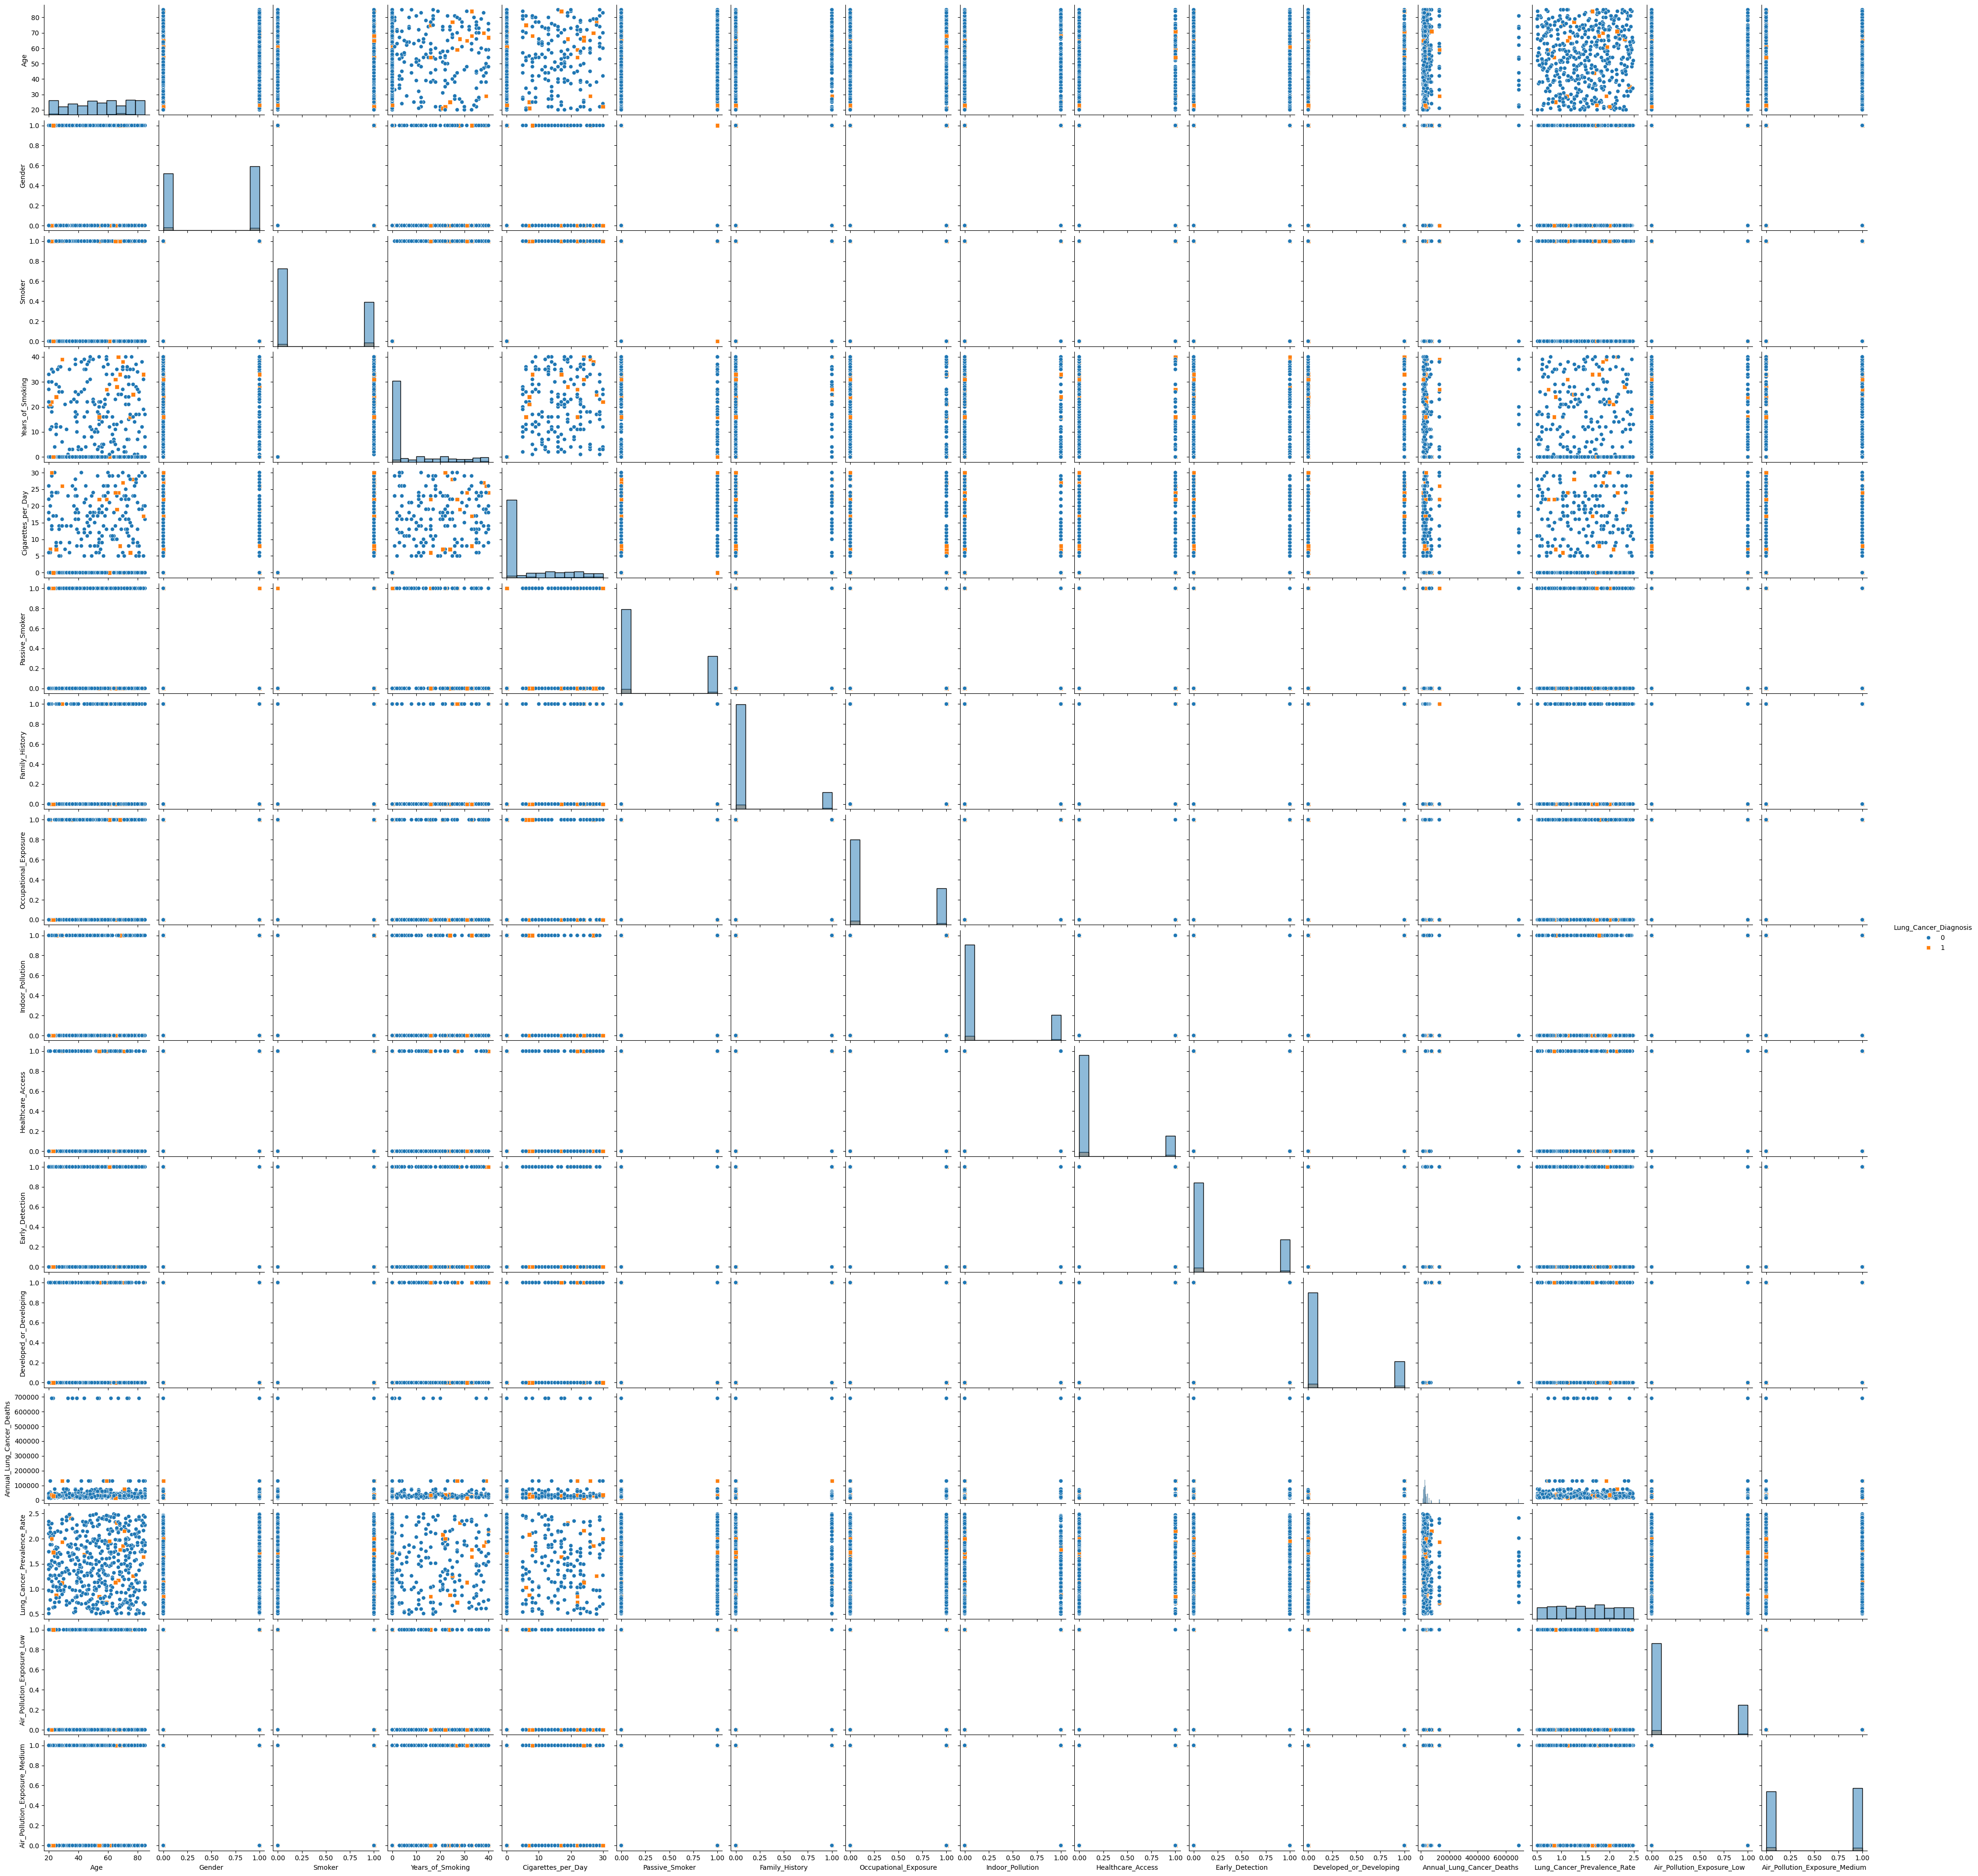

In [310]:

df_sample = df.sample(500)
sns.pairplot(df_sample, hue="Lung_Cancer_Diagnosis", kind="scatter", diag_kind="hist", markers=["o","s"])
plt.show()

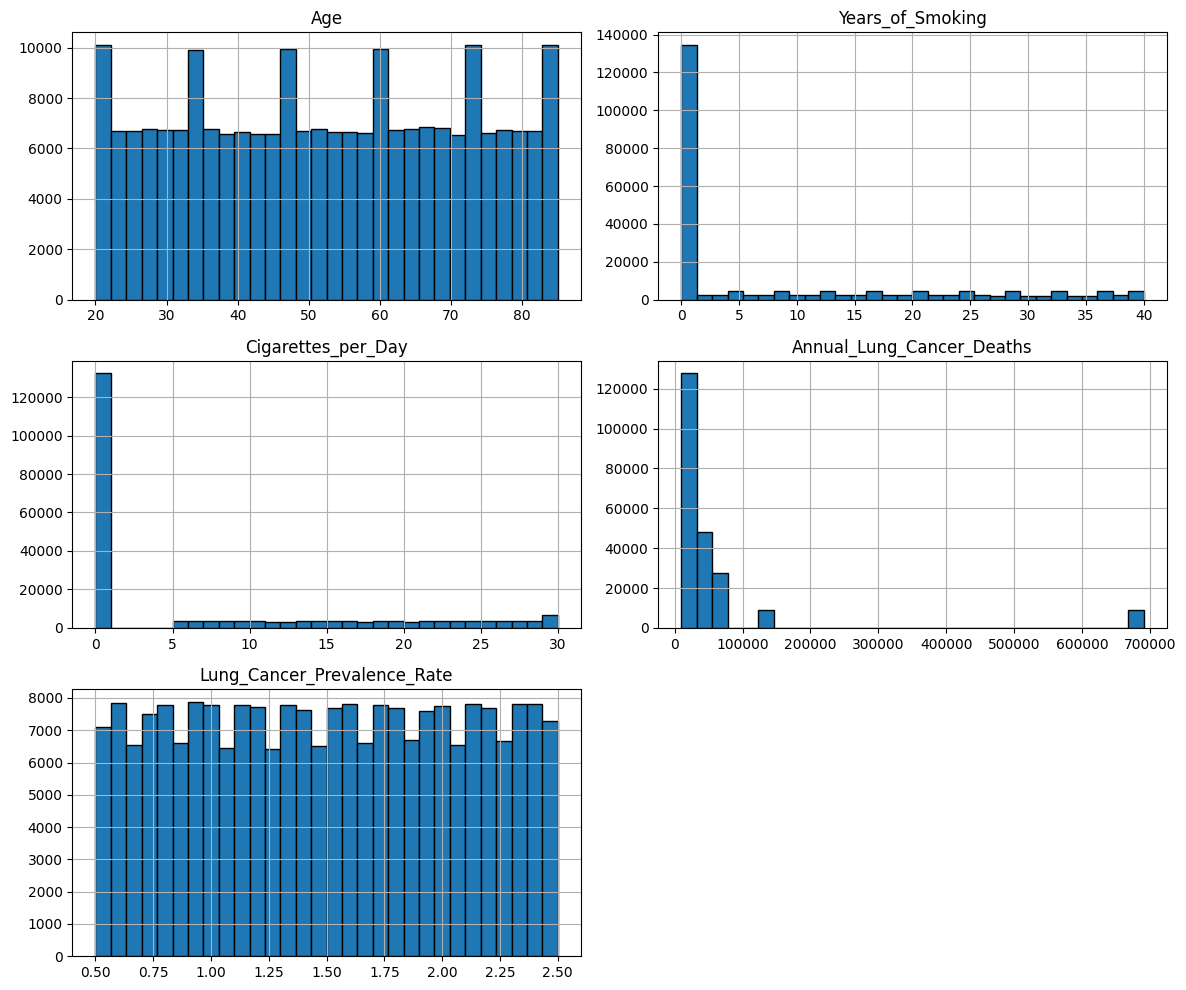

In [311]:
df[num_features].hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.tight_layout()
plt.show()

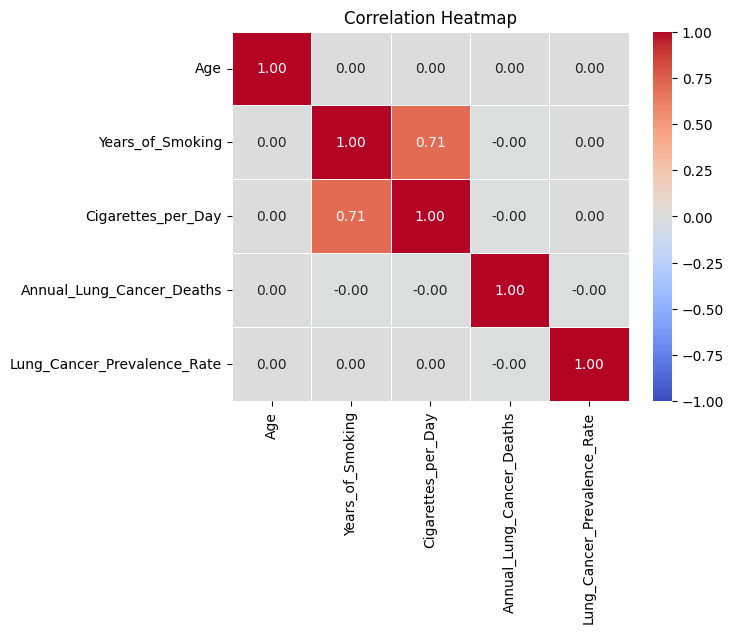

In [312]:
# Correlation between numerical features
def plot_correlation_heatmap(df):
    """ This function plots correlation heatmap for numerical features"""
    # Calculate correlation matrix
    corr_matrix = df.corr()
    # Create a heatmap
    plt.figure()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.show()

# Calling it
plot_correlation_heatmap(df[num_features])

### Machine Learning

#### Data Preprocessing and Feature Engineering

In [313]:
# Import additional libraries
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  GradientBoostingClassifier, AdaBoostClassifier

In [314]:
#we did all the investigations with df, thus data is not yet changed:
dats = data.copy()

In [315]:
# 'ID' als index instellen (if statement want by )
if 'ID' in dats.columns:
    dats.set_index('ID', inplace=True)
    print("\n'ID' column set as index!")
else:
    print("\nNo 'ID' column found, skipping index setting.")


'ID' column set as index!


In [316]:
#Feature selection (based on EDA & excluding country properties, that will not likely help predicting individual outcome)
features = ['Age', 'Gender', 
            'Smoker','Years_of_Smoking', 'Cigarettes_per_Day', 'Passive_Smoker',
            'Family_History', 'Lung_Cancer_Diagnosis', 'Healthcare_Access',
            'Air_Pollution_Exposure', 'Occupational_Exposure', 'Indoor_Pollution']
dats = dats[features]

In [317]:
# Separating features and target
X = dats.drop(columns=['Lung_Cancer_Diagnosis'])
y = dats['Lung_Cancer_Diagnosis']
print("\n Shape of X: ", X.shape)
print("\n Shape of y: ", y.shape)



 Shape of X:  (220632, 11)

 Shape of y:  (220632,)


In [318]:
# identify dtype of features:
# numerical
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\nNumerical features:\n{num_features}")

#categorical
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nCategorical features:\n{cat_features}")

#binairy (exact 2 distinct values)
bin_features = [f for f in cat_features if X[f].nunique() == 2]
print(f"\nBinairy features:\n{bin_features}")

# Multiclass (> 2 categories)
multi_cat_features = [f for f in cat_features if X[f].nunique() > 2]
print(f"\nMulticlass features:\n{multi_cat_features}")



Numerical features:
['Age', 'Years_of_Smoking', 'Cigarettes_per_Day']

Categorical features:
['Gender', 'Smoker', 'Passive_Smoker', 'Family_History', 'Healthcare_Access', 'Air_Pollution_Exposure', 'Occupational_Exposure', 'Indoor_Pollution']

Binairy features:
['Gender', 'Smoker', 'Passive_Smoker', 'Family_History', 'Healthcare_Access', 'Occupational_Exposure', 'Indoor_Pollution']

Multiclass features:
['Air_Pollution_Exposure']


In [319]:
# Preprocessing for numerical, binairy en multiclass features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),  # Numerieke features schalen
        ('bin', OneHotEncoder(drop='first'), bin_features),  # Binaire features OneHot encoden
        ('multi_cat', OneHotEncoder(drop='first'), multi_cat_features)  # Multiclass categorische features encoden
    ],
    remainder='passthrough'  # Andere features behouden zoals numeriek of binaire variabelen
)



In [323]:
# Inititalise classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth = 5, random_state=42),
    'Random Forest': RandomForestClassifier(max_depth = 5,random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Ada Boost': AdaBoostClassifier(),
   }

In [353]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imPipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
import numpy as np

def train_and_evaluate(classifiers, X, y, preprocessor, use_cv=False, cv_folds=5, sampling_method=None):
    #Sampling method: 'smote' for over-sampling, 'undersample' for under-sampling, or None 
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    # Loop through classifiers
    for model_name, model in classifiers.items():
        print(f"\nTraining {model_name}:")
        
        # Depending on the sampling method, create the appropriate resampling strategy
        if sampling_method == 'smote':
            sampler = SMOTE(sampling_strategy=0.6, random_state=42)
        elif sampling_method == 'undersample':
            sampler = RandomUnderSampler(sampling_strategy=0.6,random_state=42)
        else:
            sampler = None
        
        # Create a pipeline for preprocessing, resampling (if any), and the model
        steps = [('preprocessor', preprocessor)]
        if sampler:
            steps.append(('sampler', sampler))
        steps.append(('classifier', model))
        
        # Using imbalanced-learn's pipeline
        pipeline = imPipeline(steps=steps)
        
        try:
            if use_cv:
                # Perform cross-validation
                print(f"Performing {cv_folds}-fold cross-validation...")
                cv_recall_scores = cross_val_score(pipeline, X_train, y_train, cv=cv_folds, scoring='recall')
                print(f"Cross-Validation Recall (mean): {np.mean(cv_recall_scores):.4f}")

                cv_f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv_folds, scoring='f1_weighted')
                print(f"F1-Score: {np.mean(cv_f1_scores):.4f}")
            else:
                # Fit the model
                pipeline.fit(X_train, y_train)

                # Make predictions and evaluate
                y_pred = pipeline.predict(X_test)

                # Accuracy score
                accuracy = accuracy_score(y_test, y_pred)
                print(f"{model_name} Accuracy: {accuracy:.4f}")

                # Print classification report (precision, recall, f1-score)
                print("Classification Report:")
                print(classification_report(y_test, y_pred))
                # Print model parameters
        
                print(f"Model Parameters for {model_name}:")
                print(model.get_params())
        
                # RMSE (Root Mean Squared Error)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                print(f"RMSE: {rmse:.4f}")

                # Confusion Matrix
                cm = confusion_matrix(y_test, y_pred)
                print(f"Confusion Matrix:\n{cm}")


        except Exception as e:
            print(f"An error occurred while training {model_name}: {e}")

if y.dtypes == 'object':  # Als de target een object (strings) is
    y = y.map({'No': 0, 'Yes': 1})
    print("Target variable converted to numerical values.")
else:
    print("Target variable is already in numerical form.")
    

# Train and evaluate all models
train_and_evaluate(classifiers, X, y, preprocessor,use_cv=True,cv_folds=5, sampling_method='smote')


Target variable is already in numerical form.

Training Logistic Regression:
Performing 5-fold cross-validation...
Cross-Validation Recall (mean): 0.5412
F1-Score: 0.7844

Training Decision Tree:
Performing 5-fold cross-validation...
Cross-Validation Recall (mean): 0.6212
F1-Score: 0.7585

Training Random Forest:
Performing 5-fold cross-validation...
Cross-Validation Recall (mean): 0.5077
F1-Score: 0.7988

Training Gradient Boosting:
Performing 5-fold cross-validation...
Cross-Validation Recall (mean): 0.2176
F1-Score: 0.8877

Training Ada Boost:
Performing 5-fold cross-validation...
Cross-Validation Recall (mean): 0.5358
F1-Score: 0.7868
